# **3. Arboles de decision:**

Se selccionan las variables explicativas y la respuesta.

In [1]:

from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import math
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\PF_POSTPROCES_DATA_LIMPIA.csv")

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,Genitourinario,Piel y tejido subcutáneo,Musculoesquelético,Digestivo,Síntomas mal definidos,Trastornos mentales,Sistema nervioso,Otro,Anomalías congénitas,Órganos de los sentidos
0,Caucasian,Female,[0-10),6,25,1,1,Pediatrics,41,0,...,False,False,False,False,False,False,False,False,False,False
1,Caucasian,Female,[10-20),1,1,7,3,Other,59,0,...,False,False,False,False,False,False,False,False,False,False
2,AfricanAmerican,Female,[20-30),1,1,7,2,Other,11,5,...,False,False,False,False,False,False,False,False,False,False
3,Caucasian,Male,[30-40),1,1,7,2,Other,44,1,...,False,False,False,False,False,False,False,False,False,False
4,Caucasian,Male,[40-50),1,1,7,1,Other,51,0,...,False,False,False,False,False,False,False,False,False,False


In [3]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"NO": 0, "SI": 1})  

Se separan el conjunto de entrenamiento y test.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [5]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [7]:
arboles_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(
        criterion="gini",   # también podrías usar 'entropy' o 'log_loss'
        max_depth=None,     # sin límite de profundidad
        random_state=42
    ))
])


In [8]:
arboles_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEnc...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [9]:
def evaluar_modelo(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)

    if hasattr(modelo.named_steps["classifier"], "predict_proba"):
        y_pred_proba = modelo.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = None
        
    y_pred_proba = modelo.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title("Matriz de Confusión - Clasificador Bayesiane Base")
    plt.show()

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC - Arboles de Decision Base")
    plt.legend(loc="lower right")
    plt.show()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc
    }

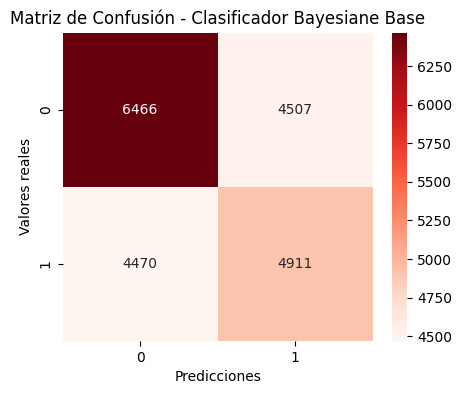

Accuracy: 0.559
Precision: 0.521
Recall: 0.524
F1-score: 0.522

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.59      0.59      0.59     10973
           1       0.52      0.52      0.52      9381

    accuracy                           0.56     20354
   macro avg       0.56      0.56      0.56     20354
weighted avg       0.56      0.56      0.56     20354



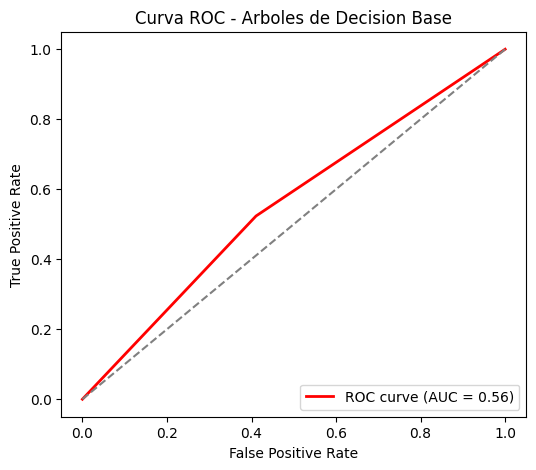

In [10]:
resultados_arboles_base = evaluar_modelo(arboles_pipeline, X_test, y_test)

El modelo de clasificación alcanza una exactitud de alrededor del 55.9%, lo que significa que acierta casi 6 de cada 10 casos, mostrando un mejor desempeño en la clase 0 que en la clase 1. La matriz de confusión evidencia que detecta más fácilmente los casos negativos (clase 0) que los positivos (clase 1), lo cual se refleja en un recall de 0.59 para la clase 0 frente a 0.52 en la clase 1. La precisión global es de 0.56 y el F1-score de 0.52, lo que señala un balance limitado entre precisión y recall, especialmente en la identificación de los positivos. La curva ROC, con un AUC de 0.56, indica que el modelo logra diferenciar las clases ligeramente mejor que el azar, aunque con una capacidad discriminativa aún baja. En conjunto, los resultados muestran que el modelo es moderadamente útil, pero requiere mejoras para incrementar su capacidad de detección en la clase 1.